# Plot Curvature of ViT Models

In [1]:
import torch
import torch.nn as nn
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from utils_henaff import *
import timm
import torchvision
import torchvision.models as models
from torchvision import transforms
import os
import sys
from fast_curvature import *
from timm.models import create_model
from timm.models.helpers import load_checkpoint

In [2]:
vit_names = ['vit_tiny_patch16_224','vit_small_patch16_224','vit_base_patch32_224','vit_base_patch16_224']


vits = {'vit_tiny_patch16_224':'Ti_16-i21k-300ep-lr_0.001-aug_none-wd_0.03-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.03-res_224.npz',
        'vit_small_patch16_224':'S_16-i21k-300ep-lr_0.001-aug_light1-wd_0.03-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.03-res_224.npz',
        'vit_base_patch32_224':'B_32-i21k-300ep-lr_0.001-aug_medium1-wd_0.03-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.03-res_224.npz',
        'vit_base_patch16_224':'B_16-i21k-300ep-lr_0.001-aug_medium1-wd_0.1-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.01-res_224.npz'}

In [3]:
v = 3
model = create_model(vit_names[v],pretrained=False)
load_checkpoint(model,os.path.join('../../straightening_models/vit_timm/',vits[vit_names[v]]))
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = nn.DataParallel(model)
model = model.to(device)
model.eval();

In [4]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Total params: ', pytorch_total_params)

Total params:  86567656


In [5]:

model_blocks = [model.module.pos_drop,
    model.module.blocks[0],
    model.module.blocks[1],
                model.module.blocks[2],
                model.module.blocks[3],
                model.module.blocks[4],
                model.module.blocks[5],
                model.module.blocks[6],
               model.module.blocks[7],
               model.module.blocks[8],
               model.module.blocks[9],
               model.module.blocks[10],
               model.module.blocks[11],
                model.module.norm,
                model.module.head
               ]


In [6]:
vid = load_all_henaff_videos_corrected(img_size=224,rgb=True)
videos = [vid['natural'].permute((0,1,4,2,3)).float().contiguous().to(device),
          vid['contrast'].permute((0,1,4,2,3)).float().contiguous().to(device), 
          vid['artificial'].permute((0,1,4,2,3)).float().contiguous().to(device)]

natural
contrast


/data1/groups/RosenholtzLab/PredStraightening/Henaff_straightening/utilities.py:44: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1055.)
  x[i].copy_( imgA ).mul_( 1-t ).add_( t, imgB )


artificial


In [7]:
path = None
curvs_natural = get_intermediate_curv(model, model_blocks,videos[0],vit=True,path=path,)
curvs_contrast = get_intermediate_curv(model, model_blocks,videos[1],vit=True,path=path)
curvs_artificial = get_intermediate_curv(model, model_blocks,videos[2],vit=True,path=path)

In [8]:
mean_natural = curvs_natural.mean(0)
mean_contrast = curvs_contrast.mean(0)
mean_artificial = curvs_artificial.mean(0)

ste_natural = curvs_natural.std(0)/curvs_natural.size(0)**0.5
ste_contrast = curvs_contrast.std(0)/curvs_contrast.size(0)**0.5
ste_artificial = curvs_artificial.std(0)/curvs_artificial.size(0)**0.5

In [9]:
natural_plot = mean_natural - mean_natural[0].repeat(mean_natural.size(0))
contrast_plot = mean_contrast - mean_contrast[0].repeat(mean_contrast.size(0))
artificial_plot = mean_artificial - mean_artificial[0].repeat(mean_artificial.size(0))

vit_base_patch16_224


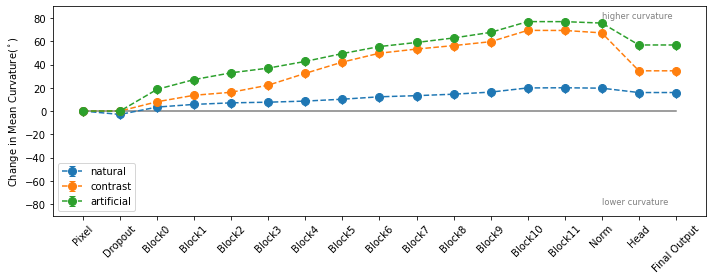

In [11]:
xlabels = ['Pixel', 'Dropout', 'Block0','Block1', 'Block2', 'Block3','Block4','Block5','Block6','Block7','Block8','Block9','Block10','Block11','Norm','Head','Final Output']
all_curves = {'layer_names':xlabels,'natural_curves':mean_natural, 'contrast_curves':mean_contrast,'artificial_curves':mean_artificial,
              'natural_ste':ste_natural, 'contrast_ste':ste_contrast,'artificial_ste':ste_artificial}
output_dir = './vit_curves'
os.makedirs(output_dir,exist_ok=True)

plt.figure(figsize=(10,4))
plt.errorbar(xlabels, natural_plot, yerr=ste_natural, marker = 'o', linestyle='--',markersize=8,label='natural',uplims=True, lolims=True)
plt.errorbar(xlabels, contrast_plot, yerr=ste_contrast, marker = 'o', linestyle='--',markersize=8,label='contrast',uplims=True, lolims=True)
plt.errorbar(xlabels, artificial_plot, yerr=ste_artificial, marker = 'o', linestyle='--',markersize=8,label='artificial',uplims=True, lolims=True)

plt.plot([xlabels[0], xlabels[-1]],[0,0], '-', color='gray')
plt.ylim([-90, 90])
plt.ylabel('Change in Mean Curvature($^\circ$)')
plt.text(xlabels[-3], -80,'lower curvature', color='gray',fontsize='small')
plt.text(xlabels[-3], 80,'higher curvature', color='gray',fontsize='small')
plt.legend(loc='lower left')
plt.xticks(rotation=45)
# plt.title('Change in Curvature Across Alexnet Blocks (with PCA)', fontsize=12)
plt.tight_layout()
# name = 'resnet50_robust_l2_3_0'
name = vit_names[v]
save_name = os.path.join(output_dir,f'{name}_curve_change.png')
print(name)
plt.savefig(save_name,dpi=300)
write_model_csv(output_dir, name, all_curves)